In [1]:
import numpy as np
import torch
from torch import nn
import operator
import import_ipynb
import ActorCriticModel
import gym

importing Jupyter notebook from ActorCriticModel.ipynb


In [2]:
#find correct hyperparameters
# RMS prop or adam
# Gradient ascent/descent
hidden_size = 32
learning_rate = 1e-3 # fine for now
max_episodes = 1000
gamma = 0.998 #decay factor, maybe change later

In [3]:
def entropy(x):
    logx = torch.log(x)
    Hx = torch.sum(x*logx)
    return Hx

In [4]:
def train(env, learning_rate, state_size, action_size, hidden_size, max_episodes, gamma):
    actor = ActorCriticModel.Actor(state_size, action_size, hidden_size)
    critic = ActorCriticModel.Critic(state_size, action_size, hidden_size)

    params = list(actor.parameters()) + list(critic.parameters())
    optimizer = torch.optim.Adam(params, lr=learning_rate)
    
    rewards_episodes = []
    episode_lengths = []
    
    losses_actor = []
    losses_critic = []
    k = 0.01
    
    for episode in range(max_episodes):
        state = env.reset()        
        done = False
        rewards = []
        values = []
        action_probs = []
        episode_length = 0
        entropies = []
        
        while not done:
            episode_length += 1
            state = torch.from_numpy(state).float()
            action_dist = actor.forward(state)
            value = critic.forward(state)
            values.append(value)
            
            action = np.random.choice(action_size, p=np.squeeze(action_dist.detach().numpy()))
            action_probs.append(action_dist[action])
            
            entropies.append(entropy(action_dist))

            state, reward, done, info = env.step(action)
            rewards.append(reward)
         
        n_steps = len(rewards)
        returns = []
        
        episode_lengths.append(episode_length)
        rewards_episodes.append(np.sum(rewards))
        
        optimizer.zero_grad()
        loss_actor, loss_critic = ActorCriticModel.calc_loss(torch.stack(action_probs), 
                                                             torch.cat(values), 
                                                             torch.tensor(rewards).float(),
                                                             gamma)                

        losses_actor.append(loss_actor.item())
        losses_critic.append(loss_critic.item())
        
        
        loss_entropy = torch.mean(torch.stack(entropies))
        loss = loss_actor + loss_critic + loss_entropy*k
        loss.backward()
        optimizer.step()
    
    plt.plot(losses_actor, label="loss actor")
    plt.legend()
    plt.savefig('loss_actor_cartpole')
    plt.show()
    plt.plot(losses_critic, label="loss critic")
    plt.legend()
    plt.savefig('loss_critic_cartpole')
    plt.show()
    return rewards_episodes, episode_lengths

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

def visualize(rewards_episodes, episode_lengths):
    smoothed_rewards = pd.Series.rolling(pd.Series(rewards_episodes), 10).mean()
    smoothed_rewards = [elem for elem in smoothed_rewards]
    
    plt.plot(rewards_episodes)
    plt.plot(smoothed_rewards)
    plt.plot()
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.savefig('rewards_cartpole')
    plt.show()

    plt.plot(episode_lengths)
    average_lengths = pd.Series.rolling(pd.Series(episode_lengths), 10).mean()
    average_lengths = [elem for elem in average_lengths]
    plt.plot(average_lengths)
    plt.xlabel('Episode')
    plt.ylabel('Episode length')
    plt.savefig('episode_lengths_cartpole')
    plt.show()

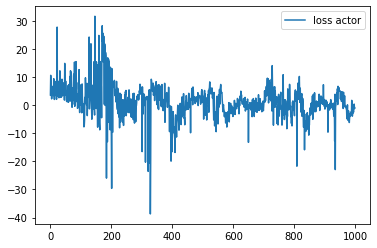

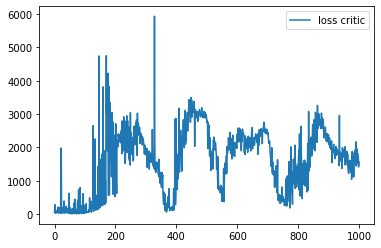

solved at episode: 502


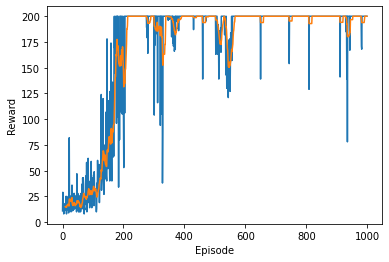

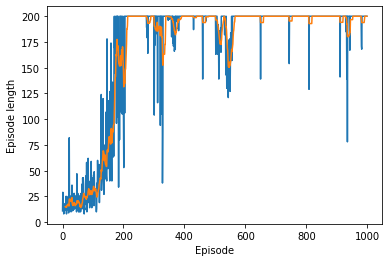

In [6]:
# Test environment just to get it all up and running
# From https://gym.openai.com/docs/
env = gym.make('CartPole-v0')
env.reset()
#env.render()
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
rewards_episodes, episode_lengths = train(env, learning_rate, state_size, 
                                          action_size, hidden_size, max_episodes, gamma)

for i in range(200, len(rewards_episodes)):
    if sum(rewards_episodes[i-200:i])/200 >= 195.0:
        print("solved at episode:", i)
        break

visualize(rewards_episodes, episode_lengths)
env.close()